In [1]:
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import xgboost as xgb
import scipy.io as sio
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import KFold, LeaveOneOut, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline

from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.geometry.spd_matrices import SPDMetricAffine

# pyriemann import
from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

# self package import
import dataloader
import bandpower
import preprocessing
import visualize
from plot_confusion_matrix import plot_confusion_matrix


INFO: Using numpy backend


# Cross validation

### Modify parameters

In [2]:
show_acc = False
output_cm = False
save_record = True
feature_folder = 'XGB_psd_LOO_resting_ASR_ref'
input_type = ['psd', 'bp', 'cov'][0]
data_folder = 'resting_ASR_ref'

n_splits = 5 if data_folder in ['bp_ica_only','resting_ASR','resting_ASR_ref'] else 10
average_regions = 1
reReference = False
low_freq, high_freq = list(range(1,50)), list(range(2,51)) # list(range(1,50)), list(range(2,51))
folder_name = '{input}_{low_bound}_{high_bound}_classification_{data_folder}_label2'.format(
    input=input_type, low_bound=low_freq[0], high_bound=high_freq[-1], data_folder=data_folder)
if not os.path.exists('./results/'+folder_name):
    os.makedirs('./results/'+folder_name)
if feature_folder and not os.path.exists('./results/'+feature_folder):
    os.makedirs('./results/'+feature_folder)

# Select models
model_names = ['naive', 'svm', 'xgboost', 'random_forest']
cv_modes = ['KFold', 'LOSO', 'LOO']
add_features = ['None', 'coherence', 'coherence_only']
preprocess_methods = ['None', 'StdScale', 'PCAVar', 'L1select']
imbalanced_methods = ['None', 'SMOTE', 'cost-sensitive']


model_names = ['xgboost']
cv_modes = ['LOO']
add_features = ['None']
preprocess_methods = ['None']
imbalanced_methods = ['SMOTE']


'''
# Model for RMDM
model_names = ['rmdm']
add_features = ['None']
preprocess_methods = ['None']
imbalanced_methods = ['None', 'SMOTE']
'''

label_formats = list(range(2,3))

### Run evaluation

Load data from .mat files...


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]
Data: resting_ASR

/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:25:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

[23:25:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


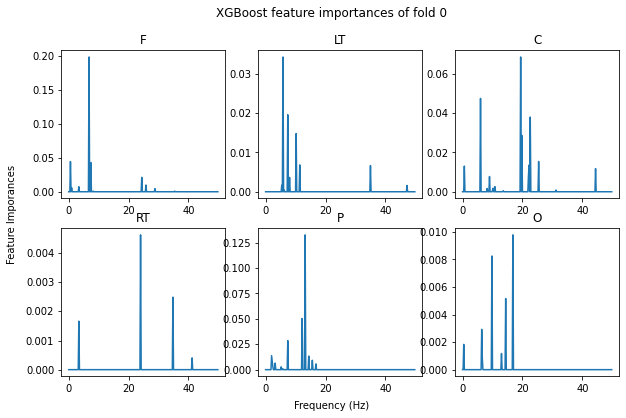

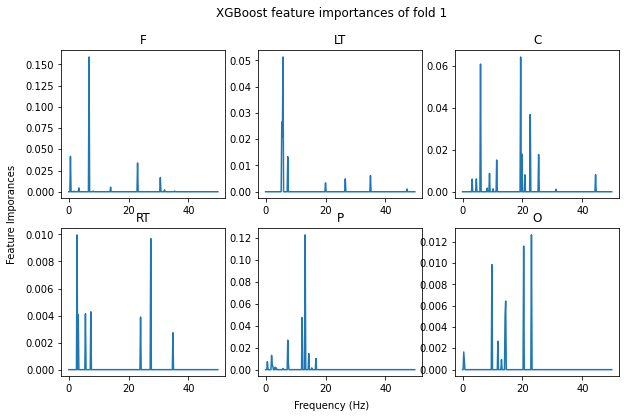

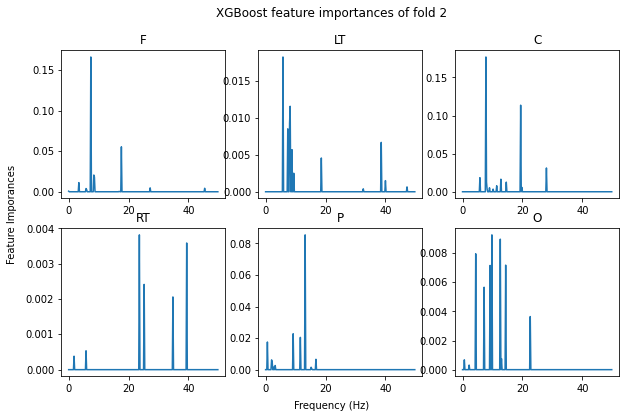

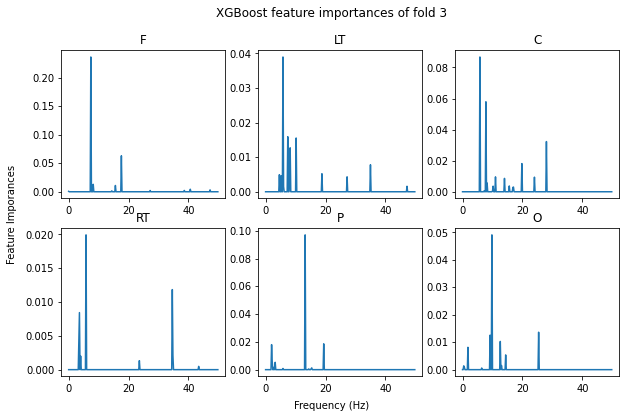

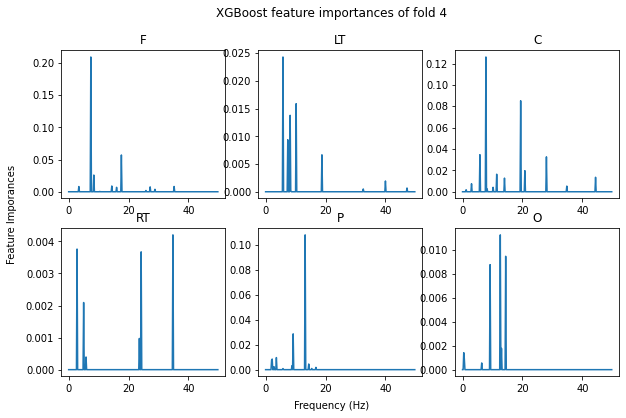

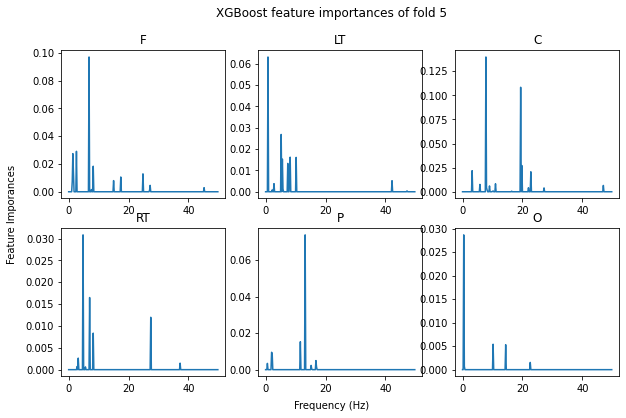

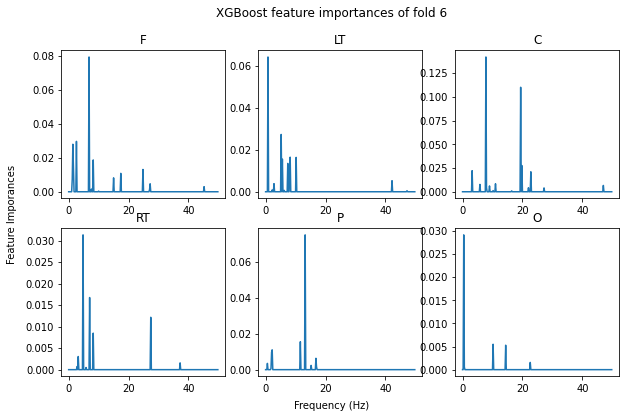

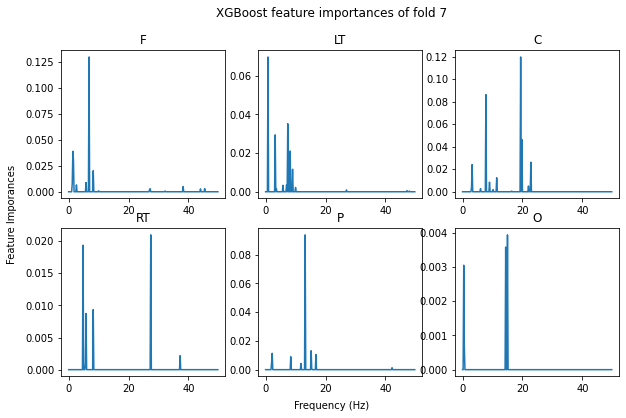

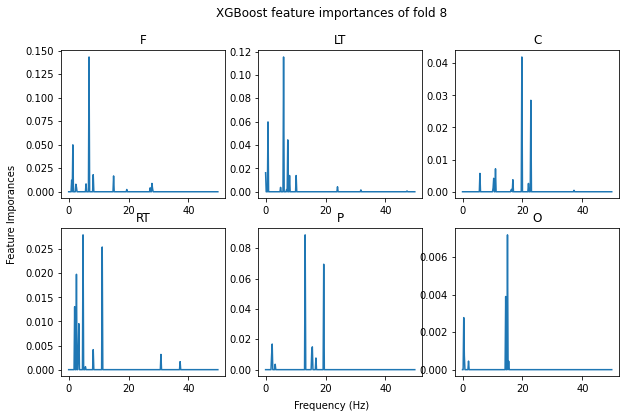

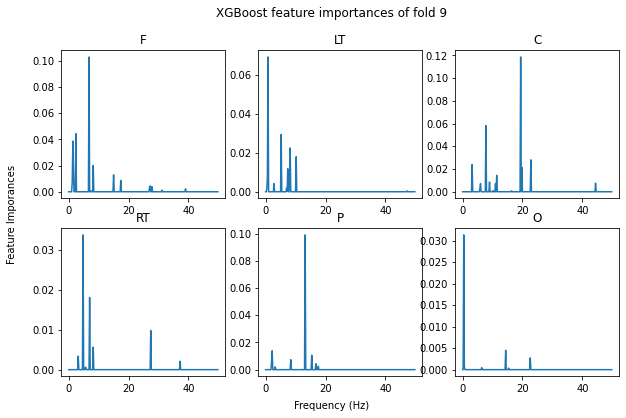

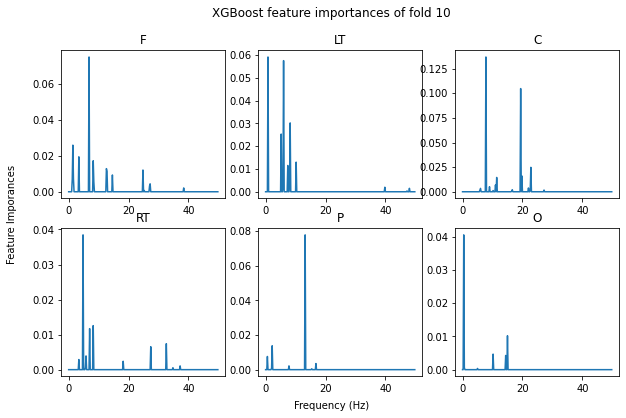

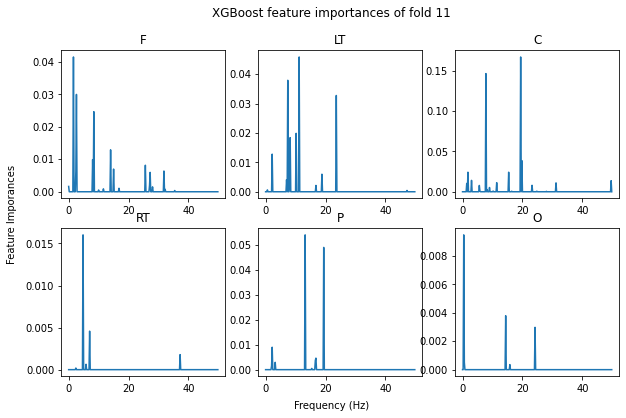

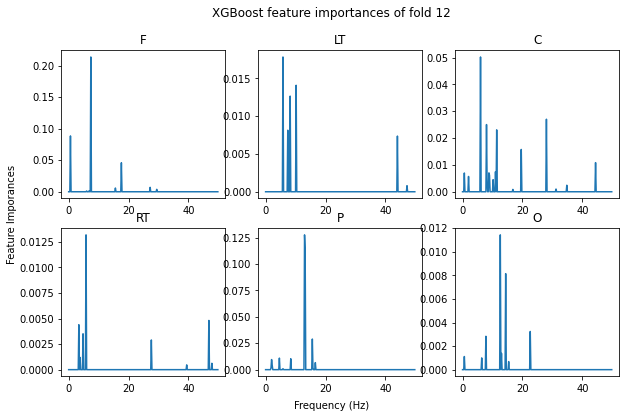

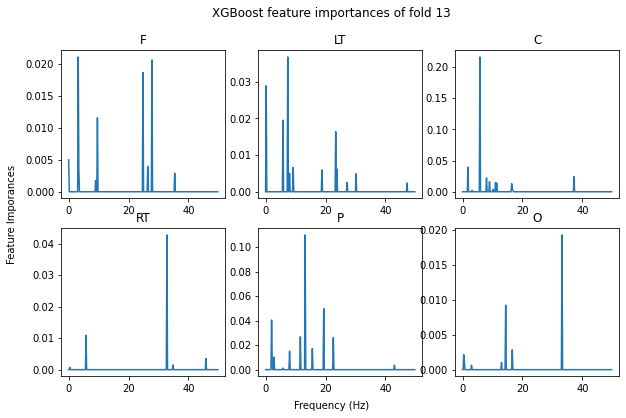

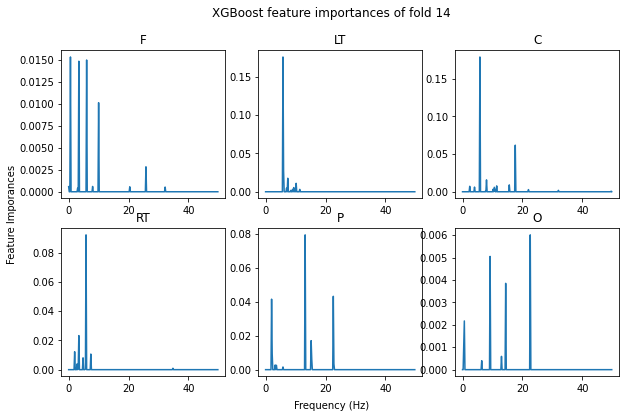

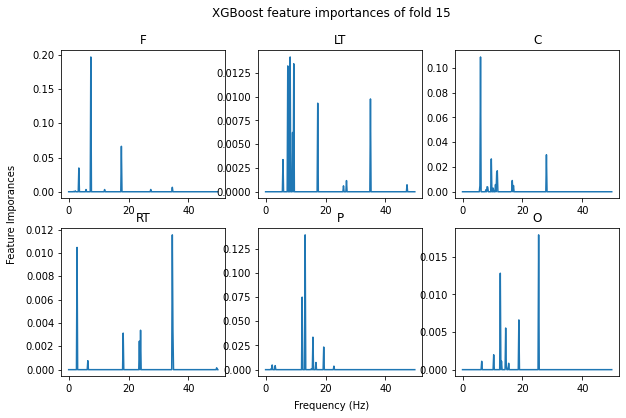

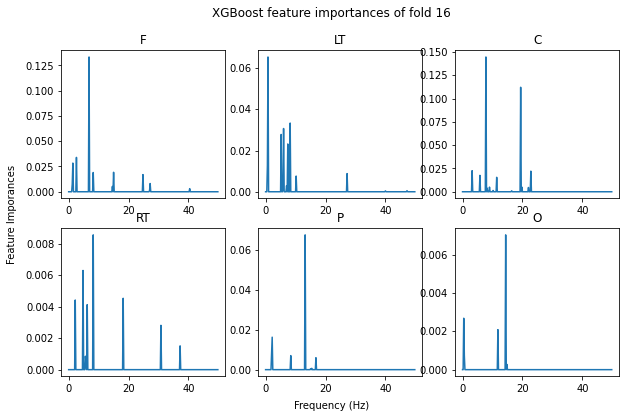

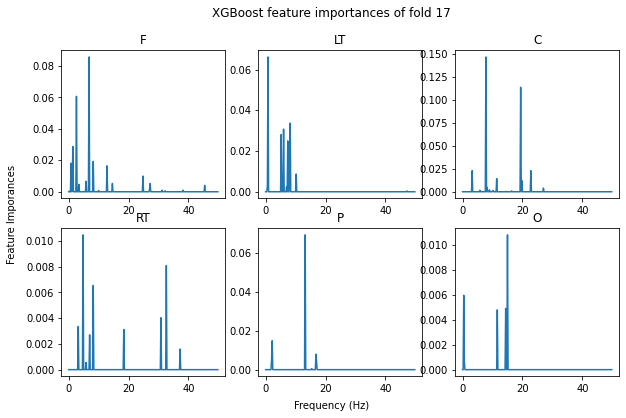

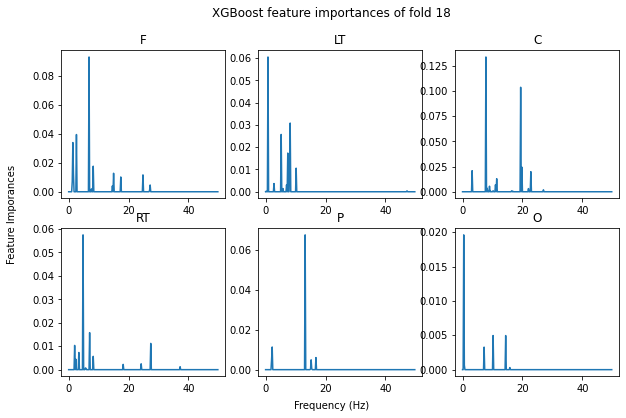

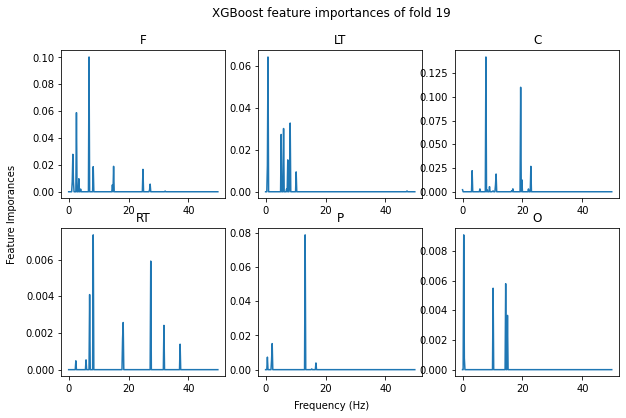

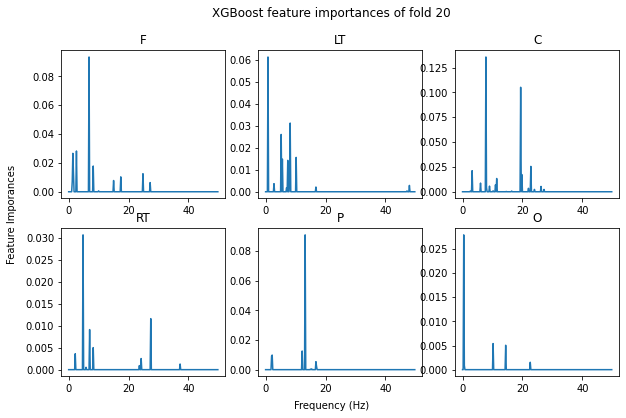

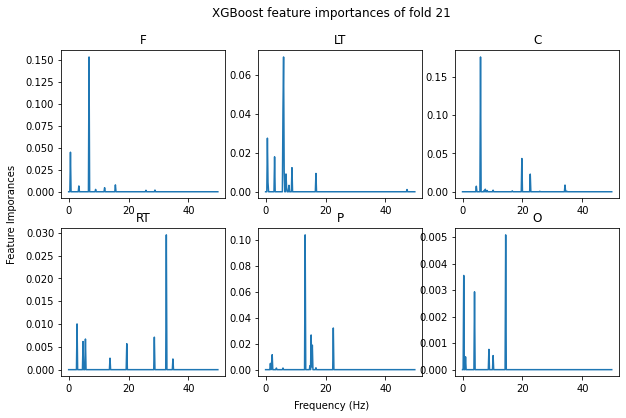

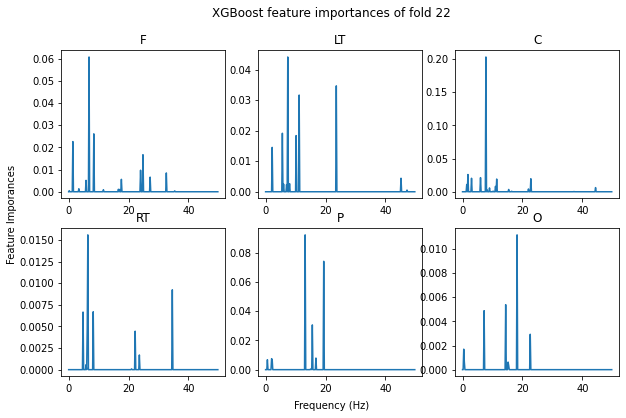

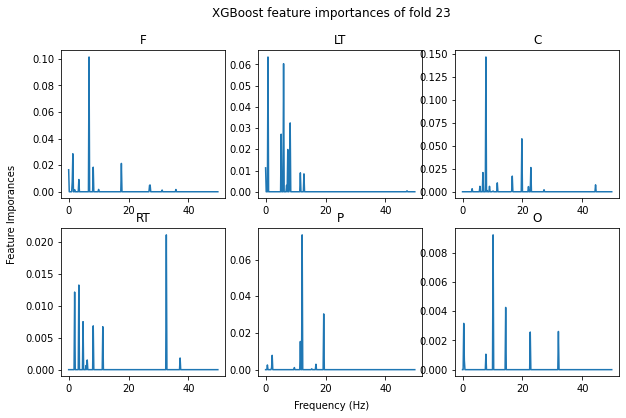

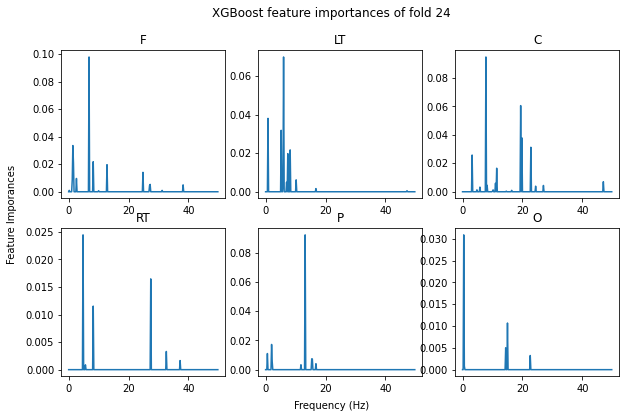

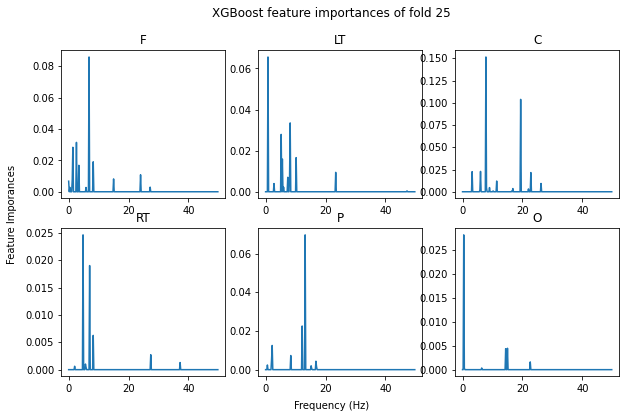

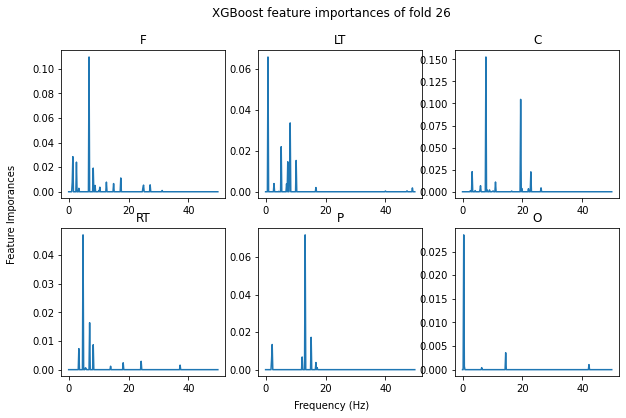

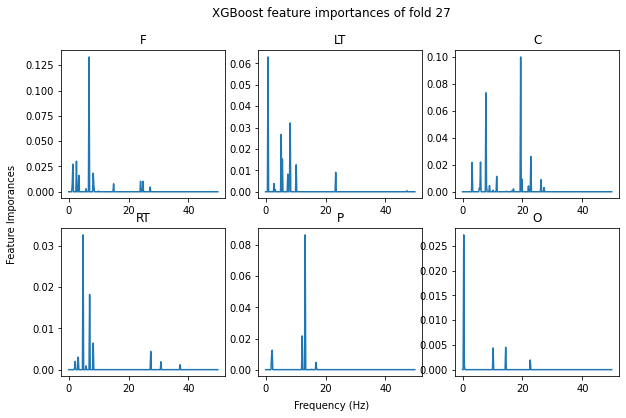

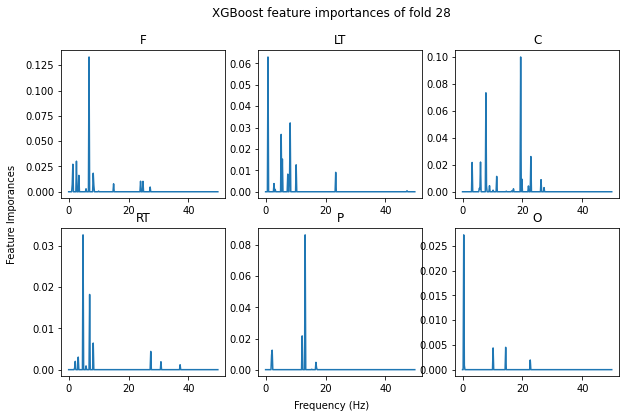

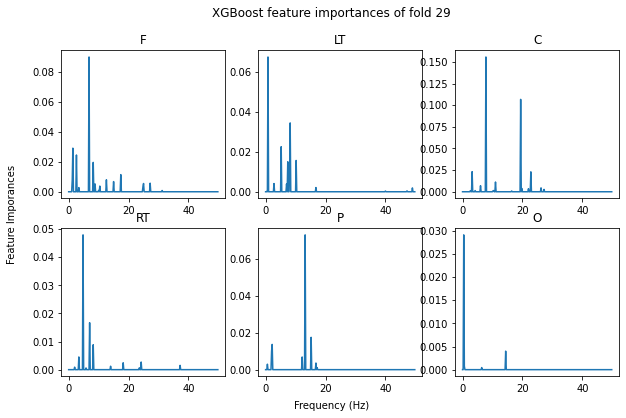

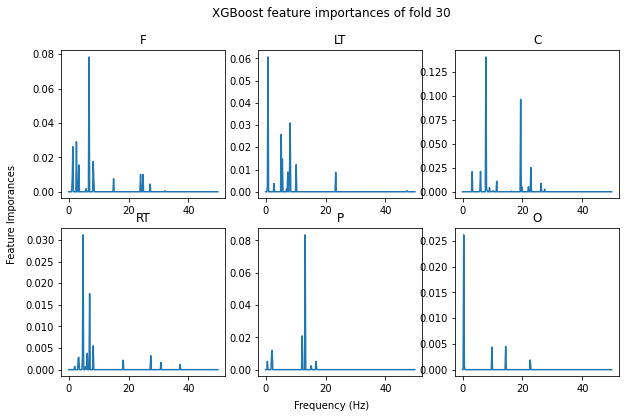

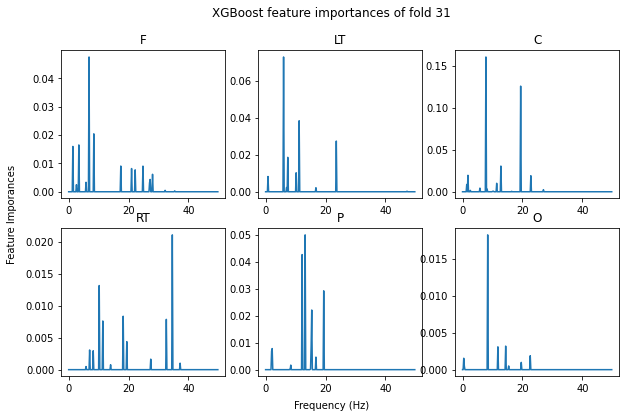

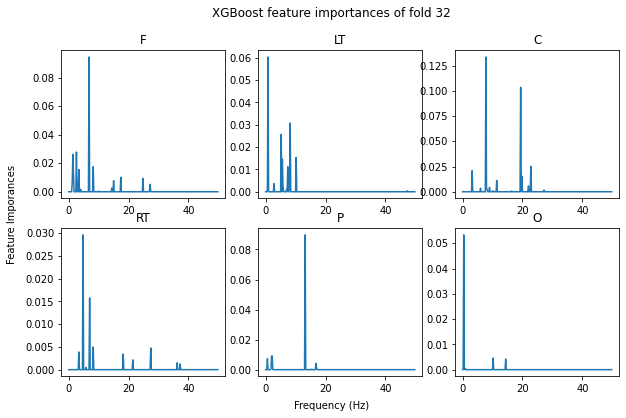

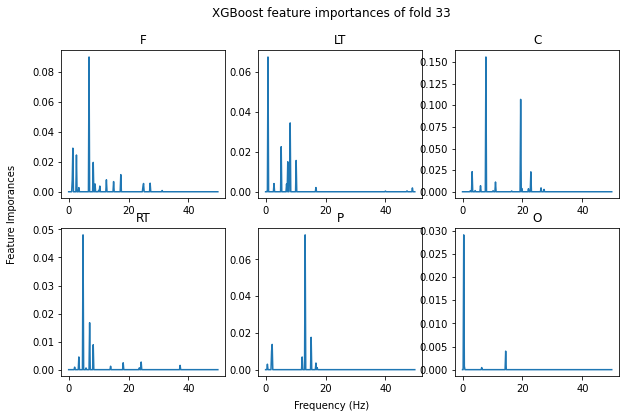

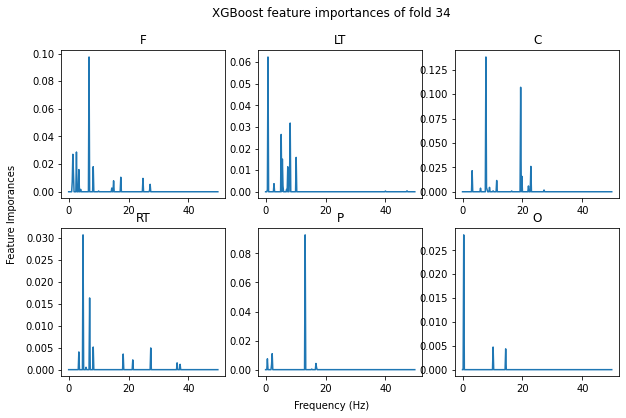

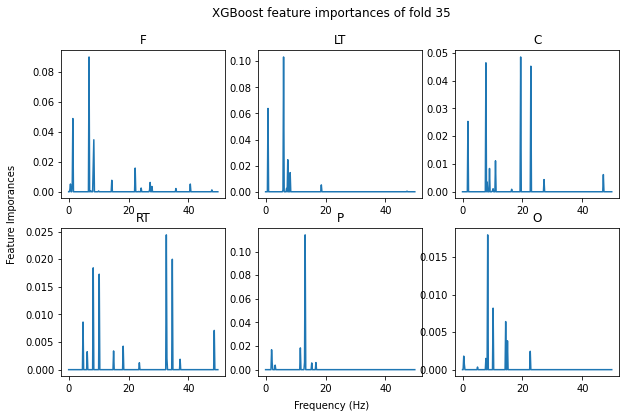

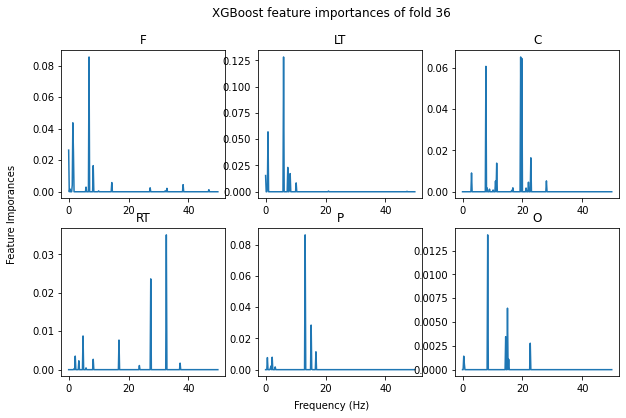

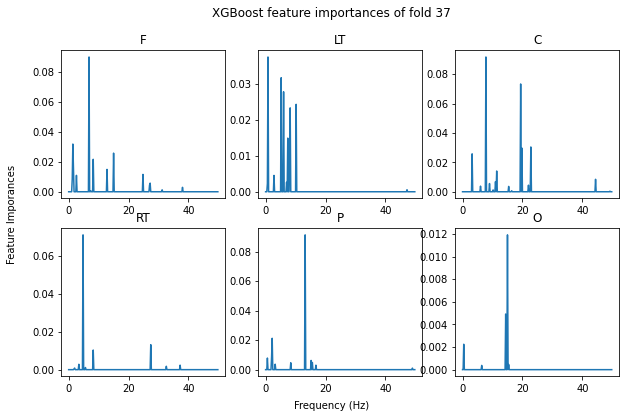

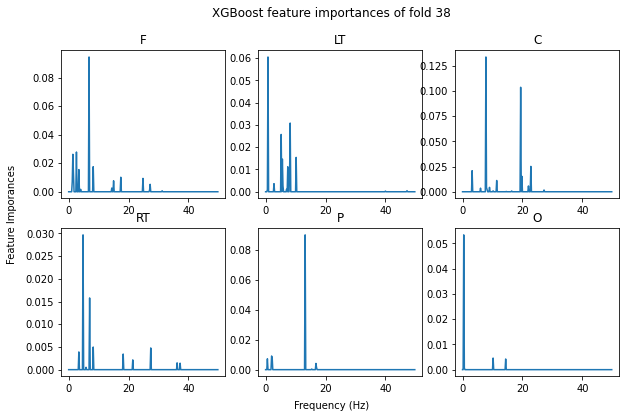

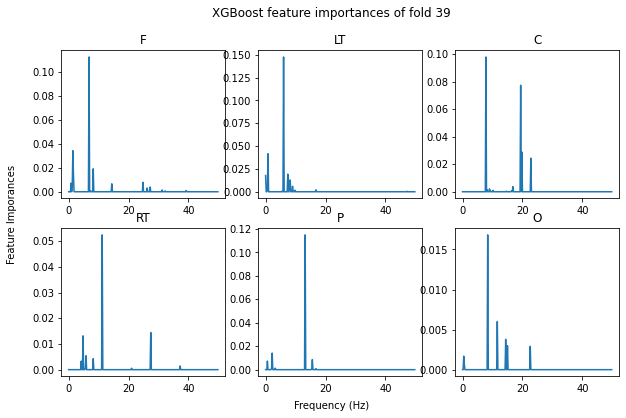

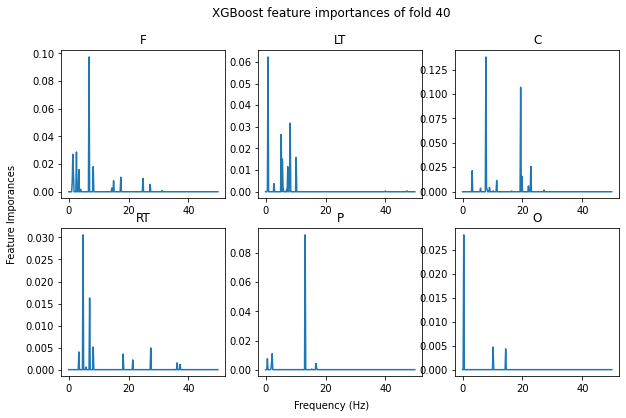

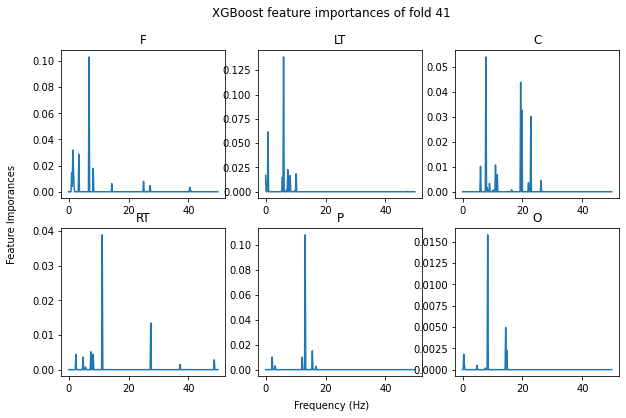

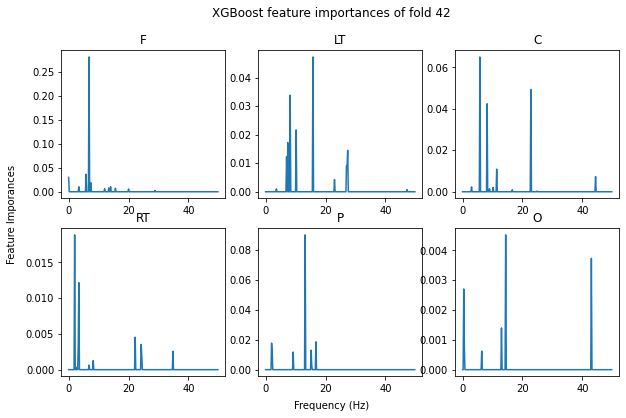

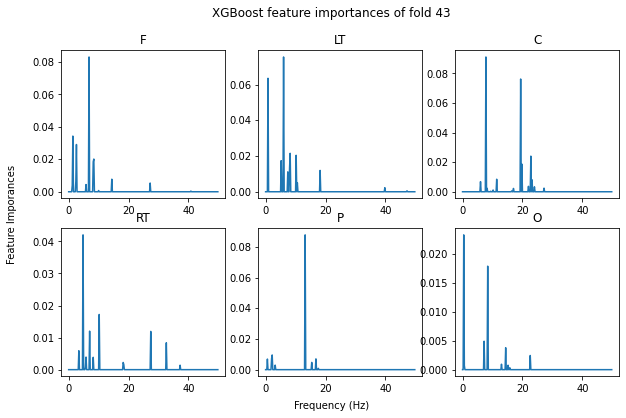

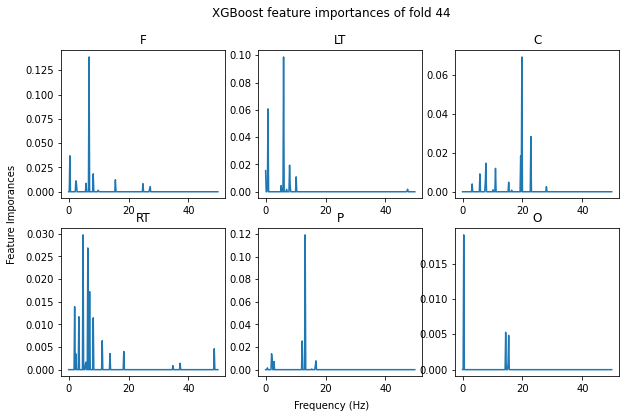

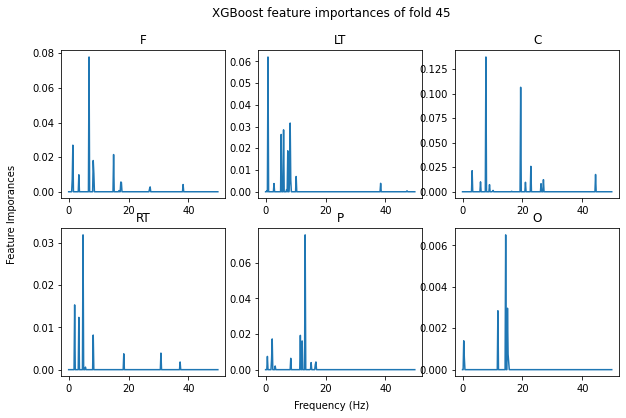

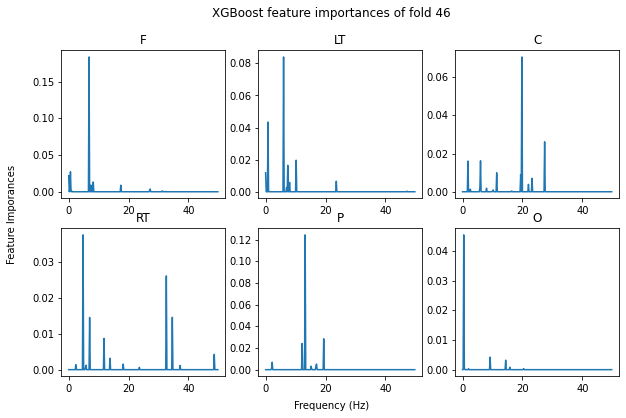

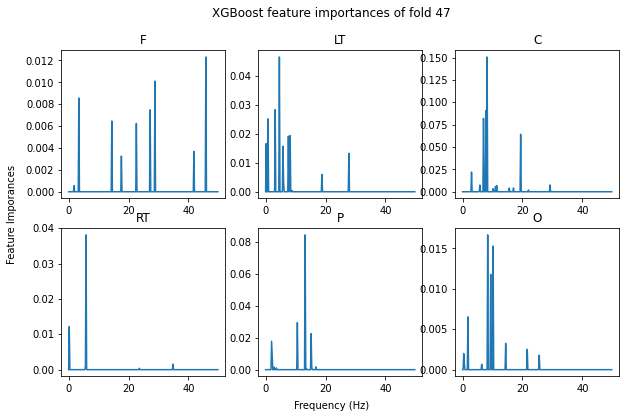

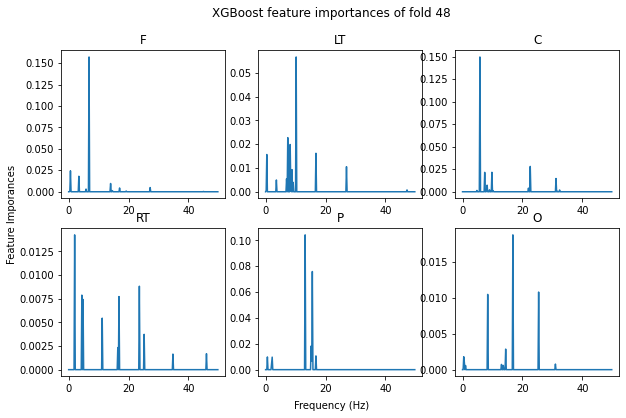

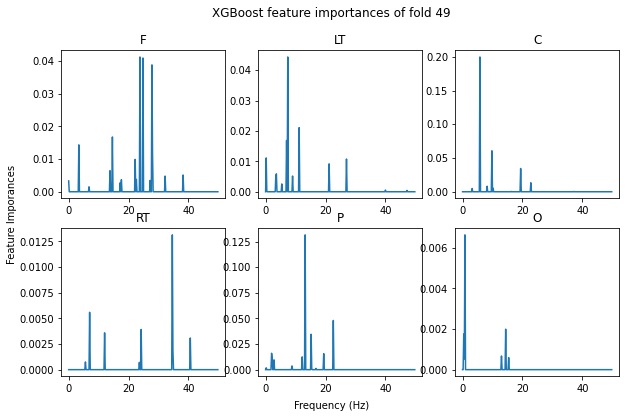

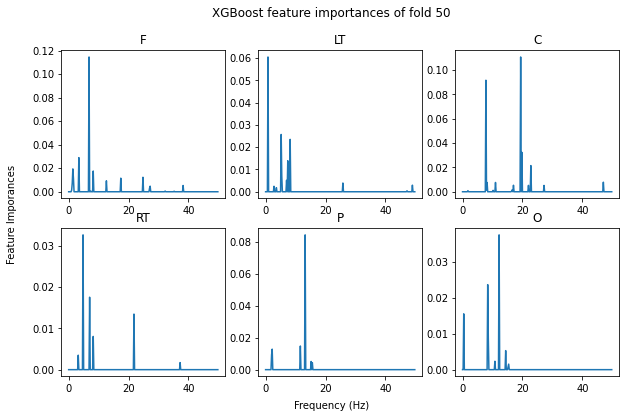

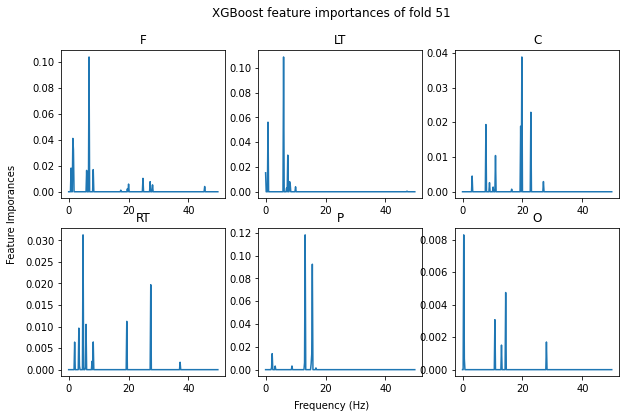

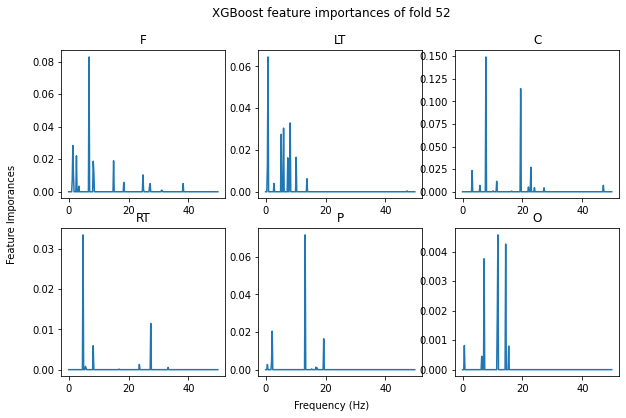

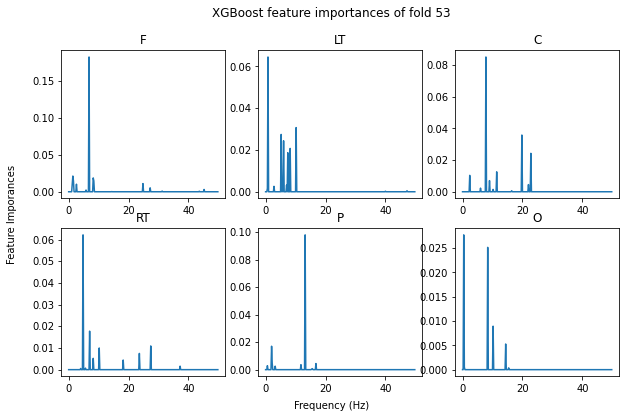

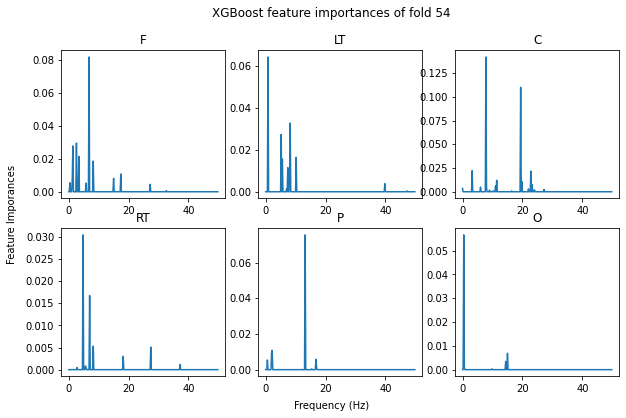

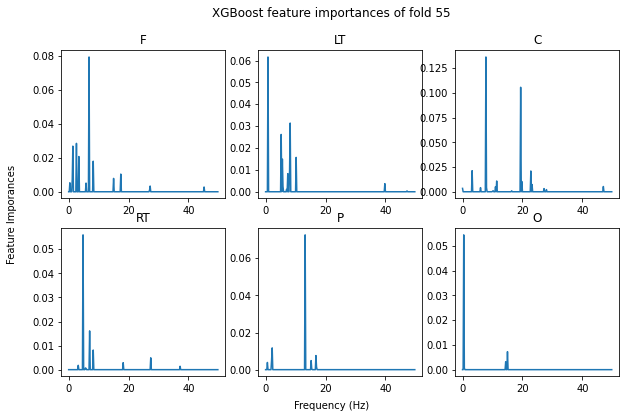

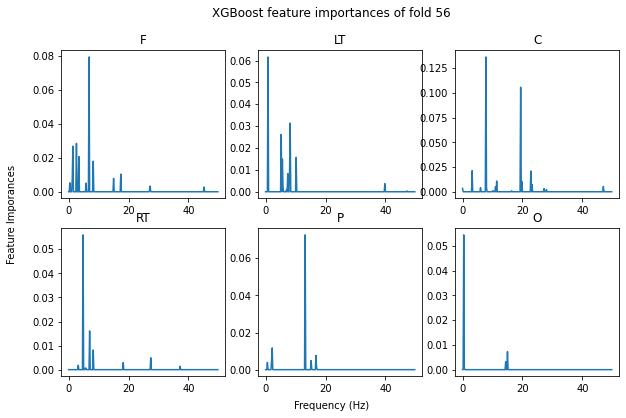

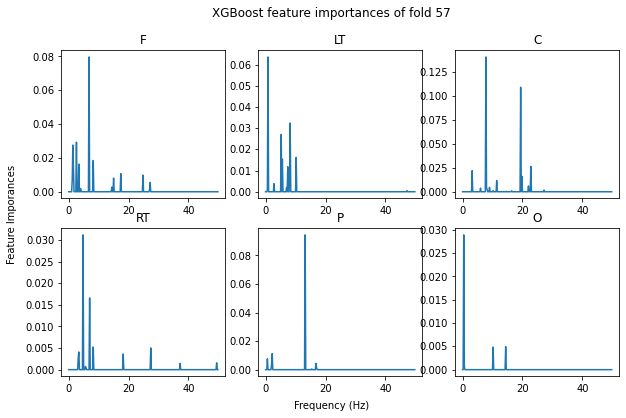

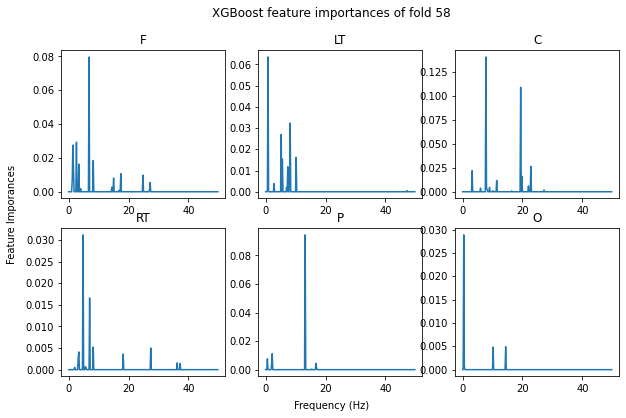

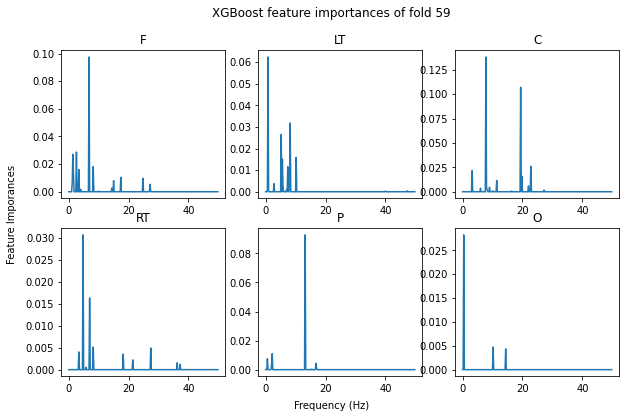

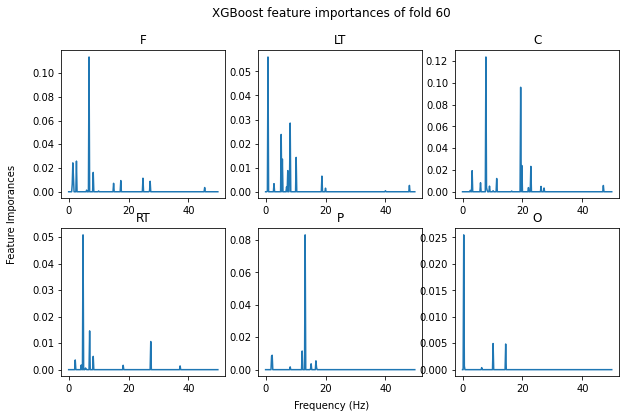

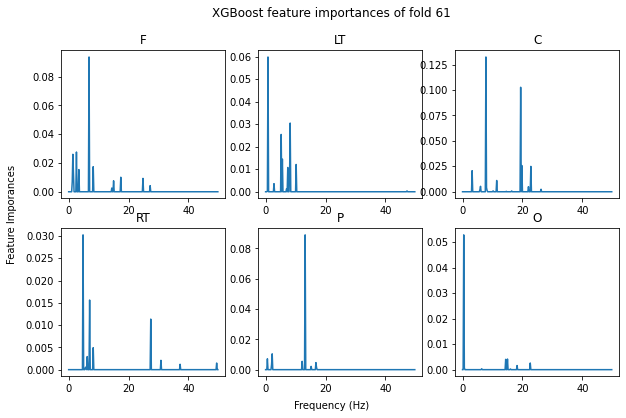

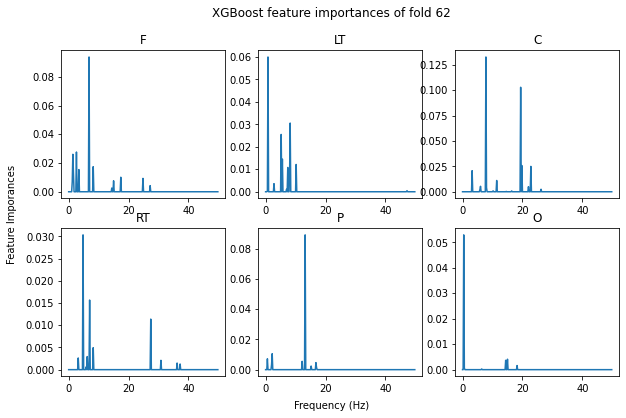

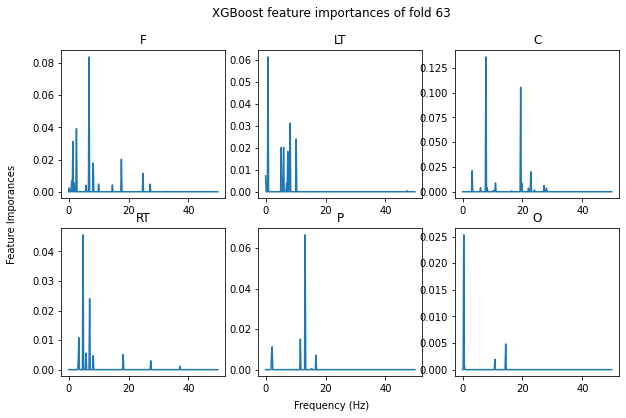

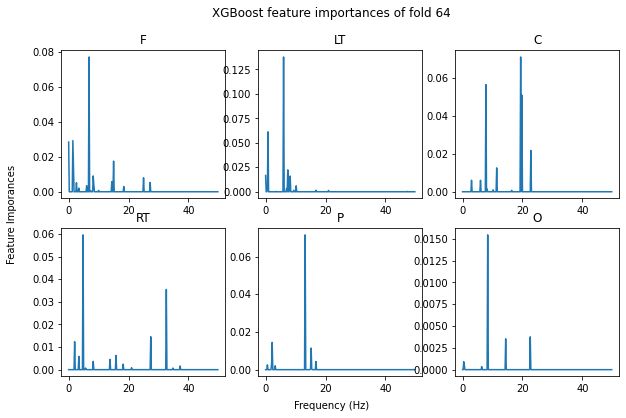

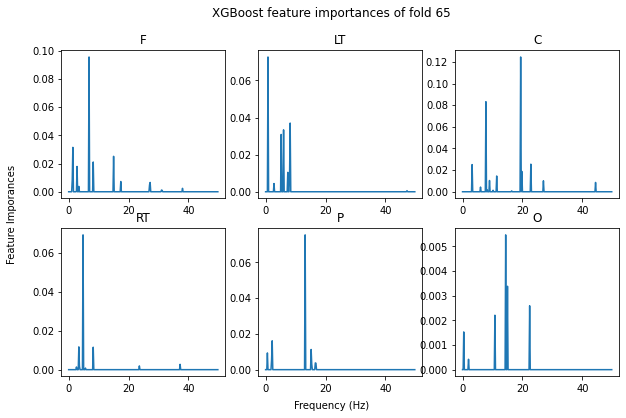

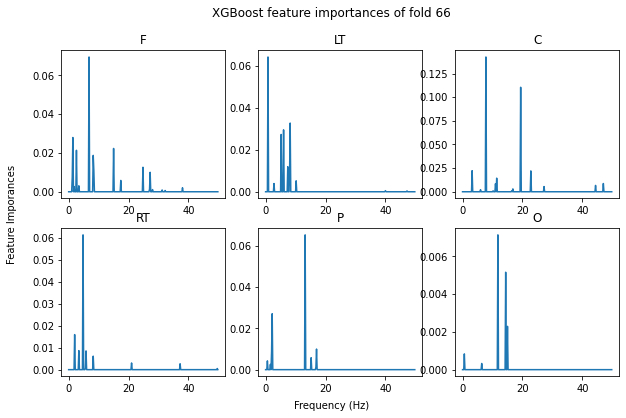

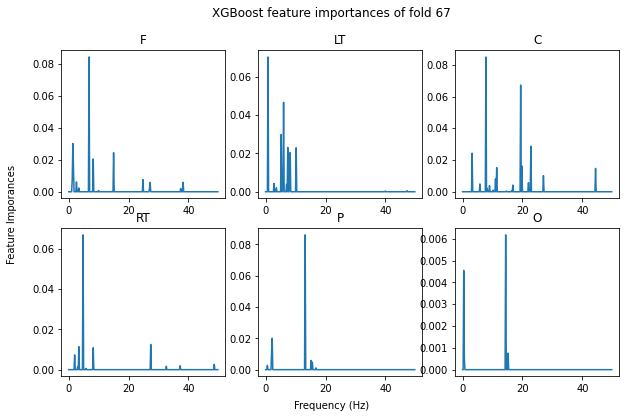

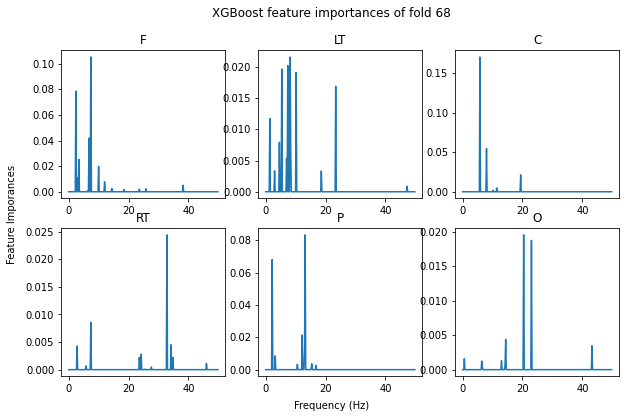

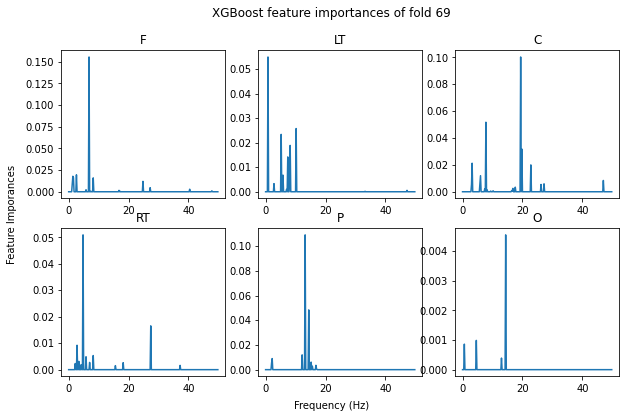

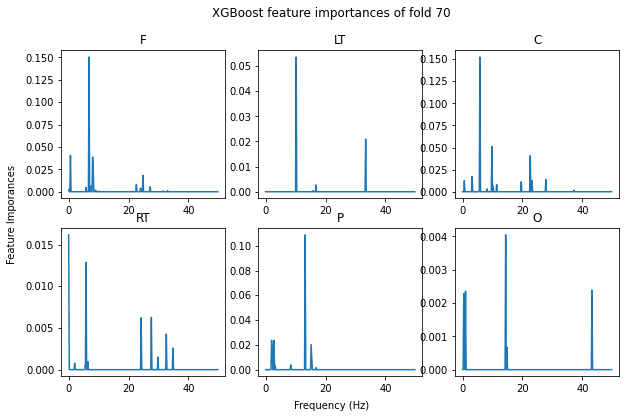

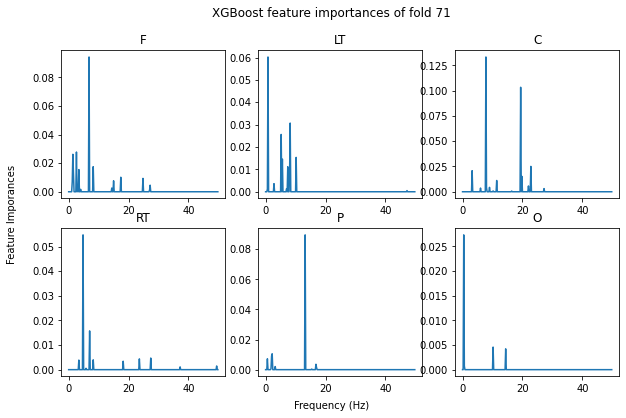

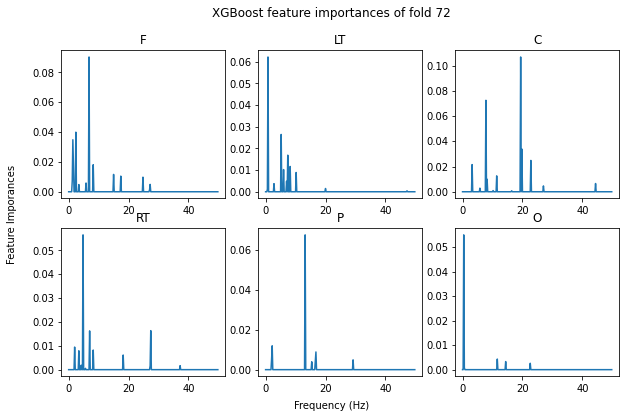

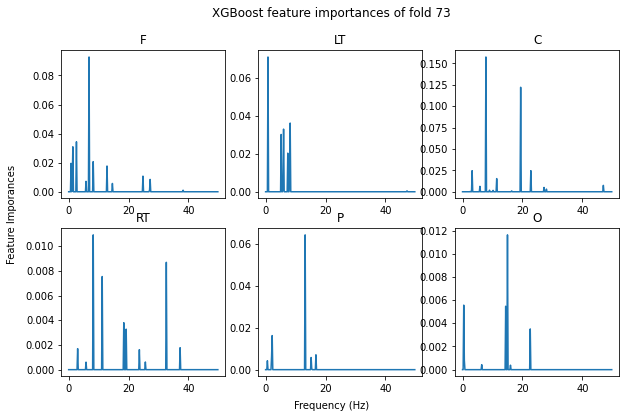

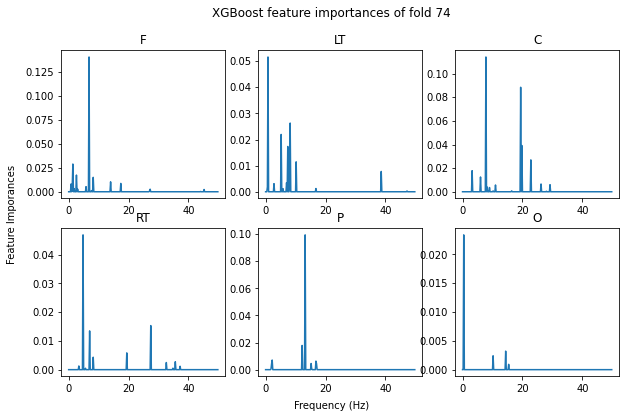

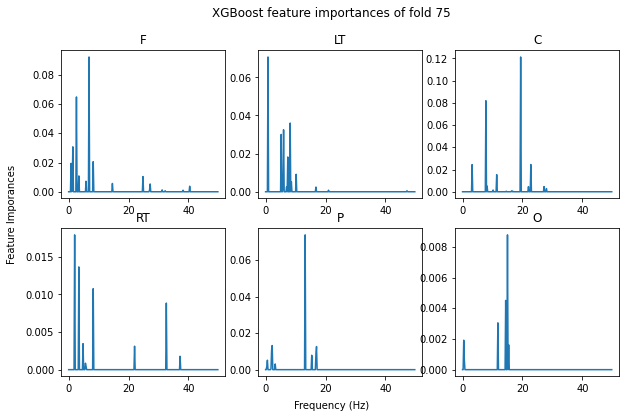

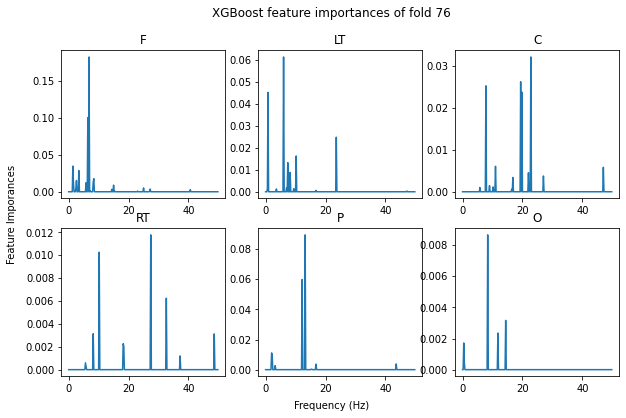

In [3]:
for label_format in label_formats:

    X, Y, df_all = dataloader.read_data(label_format=label_format, data_folder=data_folder)
    data = preprocessing.StressData(X, Y, df_all)
    
    # Remove abnormal trials
    if ['rmdm'] in model_names:
        data.remove_abnormal_trials(tol=1e4)
    
    # Remove bad trials
    if label_format < 4 and data_folder=='rawdata':
        data.remove_trials()

    if reReference:
        data.reReference('CZ')
    
    if average_regions:
        data.avg_channels_into_regions(mode=average_regions)
        
    print('Class ratio - {class0}:{class1}'.format(
        class0 = np.bincount(data.labels)[0],
        class1 = np.bincount(data.labels)[1]
    ))
        
    # Get coherence
    if 'coherence' in add_features or 'coherence_only' in add_features:
        low, high = [4, 7, 13], [7, 13, 30]
        coherence = data.get_coherence(low, high)
        
    # Transform into power
    low, high = low_freq, high_freq
    if input_type == 'psd':
        _, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)
    
        psds = np.array(psds)
        psds = psds[..., freqs<high[-1]]
        freqs = freqs[freqs<high[-1]]
    
        X = psds
        xaxis = np.array(freqs)
    elif input_type == 'bp':
        powers, _, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)
    
        X = powers
        xaxis = np.array(low)
    else:
        X = data.get_covariance()
    
    for model_name, cv_mode, added_feature, preprocess_name, imbalanced_method in itertools.product(model_names, cv_modes, add_features, preprocess_methods, imbalanced_methods):

        file_name = '%s/label%d_%s_%s_%s_%s_%s.csv'%(folder_name, label_format, model_name, cv_mode, added_feature, preprocess_name, imbalanced_method)
        description = 'Data: %s, Label: %d, Model: %s, CV mode: %s, Added features: %s, Preprocess: %s, Imblanced: %s'%(
            data_folder, label_format, model_name, cv_mode, added_feature, preprocess_name, imbalanced_method)
        print(description)
        
        num_sample = len(X)
        inputs = np.array(X)
        if input_type != 'cov':
            inputs = inputs.reshape((len(inputs),-1))
            
        # Add additional features
        if added_feature == 'coherence':
            inputs = np.concatenate((inputs, coherence), axis=1)
        elif added_feature == 'coherence_only':
            inputs = coherence

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=23)
        loo = LeaveOneOut()
        S = data.df_all['subject'].values
        if cv_mode == 'KFold':
            folds = kf.split(inputs)
        elif cv_mode == 'LOO':
            folds = loo.split(inputs)
        else:    # Leave one subject out
            folds = np.unique(S)
        folds = list(folds)

        train_acc_list = []
        val_acc_list = []
        train_recall_list = []
        val_recall_list = []
        train_prec_list = []
        val_prec_list = []
        train_f1_list = []
        val_f1_list = []
        num_val_list = []
        chance_list = []
        fold_name_list = []
        
        train_confusion = np.zeros((2,2))
        val_confusion = np.zeros((2,2))
        if added_feature != 'coherence_only':
            if preprocess_name == 'L1select':
                selected_features = {region:[] for region in ['F','LT','C','RT','P','O']}
            else:
                selected_features = {region: np.zeros(len(xaxis)) for region in ['F','LT','C','RT','P','O']}    # For XGB feature importances
                all_feature_importances = {region: np.zeros((len(folds), len(xaxis))) for region in ['F','LT','C','RT','P','O']}
        if added_feature in ['coherence','coherence_only']:
            selected_features = {'coherence': []}

        if show_acc:
            print('Sub  \t Chance\t | Train | Val')
        for i_fold, fold in enumerate(folds):
            if cv_mode in ['KFold','LOO']:
                train_indices = fold[0]
                val_indices = fold[1]
            else:
                subID = fold
                train_indices = np.where(S!=subID)[0]
                val_indices = np.where(S==subID)[0]

            X_train, Y_train = inputs[train_indices,...], data.labels[train_indices]
            X_val, Y_val = inputs[val_indices,...], data.labels[val_indices]

            # Preprocessing features
            if preprocess_name == 'StdScale':
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            elif preprocess_name == 'L1select':
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
                X_train, X_val, sel_ = preprocessing.select_features(X_train, X_val, Y_train)
                
                if 'L1' in feature_folder:
                    
                    if added_feature != 'coherence_only':
                        # Plot L1 selected features
                        fig, axs = plt.subplots(2, 3, figsize=(10,6))
                        for i_channel in range(6):

                            row, col = i_channel//3, i_channel%3

                            coef = sel_.estimator_.coef_[0,i_channel*len(xaxis):(i_channel+1)*len(xaxis)]

                            axs[row][col].plot(xaxis, coef)
                            axs[row][col].set_title(data.df_all.loc[0,'channels'][i_channel])

                            selected_features[data.df_all.loc[0,'channels'][i_channel]].append(list(xaxis[np.where(coef!=0)[0]]))

                        fig.suptitle('L1 coefficients of fold %d'%(i_fold))
                        fig.text(0.5, 0.05, 'Frequency (Hz)', ha='center')
                        fig.text(0.05, 0.5, 'Coefficients', va='center', rotation='vertical')
                        fig.savefig('./results/{L1_feature_folder}/{i_fold}.png'.format(
                            L1_feature_folder=feature_folder,i_fold=i_fold))

                    if added_feature == 'coherence':
                        coef = sel_.estimator_.coef_[0, 6*len(xaxis):]
                        selected_features[added_feature].append(list(np.where(coef!=0)[0]))
                        
                    if added_feature == 'coherence_only':
                        coef = sel_.estimator_.coef_[0]
                        selected_features['coherence'].append(list(np.where(coef!=0)[0]))
                
            elif preprocess_name in ['PCAVar', 'PCAL1select', 'SparsePCA']:
                if preprocess_name == 'PCAVar':
                    n_components = 0.9
                elif preprocess_name == 'PCAL1select':
                    n_components = np.min(X_train.shape)
                elif preprocess_name == 'SparsePCA':
                    n_components = 10
                
                scaler, pca = StandardScaler(), PCA(n_components=n_components)
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
                
                X_train = pca.fit_transform(X_train)
                X_val = pca.transform(X_val)
                
                if preprocess_name == 'PCAL1select':
                    X_train, X_val, _ = preprocessing.select_features(X_train, X_val, Y_train)
            
            # Resample training data
            if imbalanced_method == 'SMOTE':
                sm = SMOTE(random_state=23)
                if input_type == 'cov':
                    num_channels = X_train.shape[1]
                    X_train = X_train.reshape((len(X_train),-1))
                    X_train, Y_train = sm.fit_resample(X_train, Y_train)
                    X_train = X_train.reshape((len(X_train), num_channels, num_channels))
                else:
                    X_train, Y_train = sm.fit_resample(X_train, Y_train)
                

            # Train classifier
            num_neg, num_pos = tuple(np.bincount(Y_train))

            if model_name == 'svm':
                if imbalanced_method == 'cost-sensitive':
                    clf = svm.SVC(class_weight='balanced')
                else:
                    clf = svm.SVC()
            elif model_name == 'xgboost':
                if imbalanced_method == 'cost-sensitive':
                    clf = xgb.XGBClassifier(scale_pos_weight=num_neg/num_pos)
                else:
                    clf = xgb.XGBClassifier()
            elif model_name == 'naive':
                if imbalanced_method == 'cost-sensitive':
                    clf = GaussianNB(priors = [num_pos/len(Y_train), num_neg/len(Y_train)])
                else:
                    clf = GaussianNB()
            elif model_name == 'random_forest':
                if imbalanced_method == 'cost-sensitive':
                    clf = RandomForestClassifier(max_depth=2, class_weight='balanced', random_state=23)
                else:
                    clf = RandomForestClassifier(max_depth=2)
            elif model_name == 'rmdm':
                clf = MDM(metric=dict(mean='riemann', distance='riemann'))

            clf.fit(X_train, Y_train)

            # Test classifier
            pred_train = clf.predict(X_train)
            pred_val = clf.predict(X_val)

            train_confusion += confusion_matrix(Y_train, pred_train, labels=[0,1])
            val_confusion += confusion_matrix(Y_val, pred_val, labels=[0,1])

            train_acc = accuracy_score(Y_train, pred_train)
            val_acc = accuracy_score(Y_val, pred_val)

            train_recall = recall_score(Y_train, pred_train)
            val_recall = recall_score(Y_val, pred_val)

            train_prec = precision_score(Y_train, pred_train)
            val_prec = precision_score(Y_val, pred_val)

            train_f1 = f1_score(Y_train, pred_train)
            val_f1 = f1_score(Y_val, pred_val)
                
            fold_name = 'Fold %d'%(i_fold) if cv_mode in ['KFold','LOO'] else 'Sub %d'%(subID)
            chance = np.sum(Y_train)/len(Y_train)
            chance = (1-chance) if chance<0.5 else chance

            train_acc_list.append(train_acc)
            val_acc_list.append(val_acc)
            train_recall_list.append(train_recall)
            val_recall_list.append(val_recall)
            train_prec_list.append(train_prec)
            val_prec_list.append(val_prec)
            train_f1_list.append(train_f1)
            val_f1_list.append(val_f1)
            num_val_list.append(len(Y_val))
            fold_name_list.append(fold_name)
            chance_list.append(chance)

            if show_acc:
                print('%s\t %.1f%%\t | %.1f%% | %.1f%%'%(fold_name, chance*100, train_acc*100, val_acc*100))
            
            if output_cm:
                fileName_cm = './results/' + file_name[:file_name.find('.')] + '_' + fold_name
                plot_confusion_matrix(Y_train, pred_train, np.array(['Normal','Increase']), 
                                     fileName='%s_train.png'%(fileName_cm), title=fold_name)
                plot_confusion_matrix(Y_val, pred_val, np.array(['Normal','Increase']), 
                                     fileName='%s_val.png'%(fileName_cm), title=fold_name)
        
            if 'XGB' in feature_folder:
                # Plot L1 selected features
                fig, axs = plt.subplots(2, 3, figsize=(10,6))
                for i_channel in range(6):

                    region = data.df_all.loc[0,'channels'][i_channel]
                    row, col = i_channel//3, i_channel%3

                    coef = clf.feature_importances_[i_channel*len(xaxis):(i_channel+1)*len(xaxis)]

                    axs[row][col].plot(xaxis, coef)
                    axs[row][col].set_title(data.df_all.loc[0,'channels'][i_channel])

                    all_feature_importances[region][i_fold] = coef
                    all_feature_importances['freq'] = xaxis
                    selected_features[region] += coef / len(folds)
                    
                fig.suptitle('XGBoost feature importances of fold %d'%(i_fold))
                fig.text(0.5, 0.05, 'Frequency (Hz)', ha='center')
                fig.text(0.05, 0.5, 'Feature Imporances', va='center', rotation='vertical')
                fig.savefig('./results/{folder}/{i_fold}.png'.format(
                    folder=feature_folder,i_fold=i_fold))
        
        tp, fp = val_confusion[1,1], val_confusion[0,1]
        tn, fn = val_confusion[0,0], val_confusion[1,0]
        
        avg_acc = (tp+tn) / (tp+tn+fp+fn)
        avg_recall = tp / (tp+fn) if tp+fn!=0 else 0
        avg_prec = tp / (tp+fp) if tp+fp!=0 else 0
        avg_f1 = 2 / (1/avg_recall+1/avg_prec) if avg_recall!=0 and avg_prec!=0 else 0
        
        if show_acc:
            print('Average val acc: %.1f%%'%(avg_acc*100))

        # Save result as csv file
        df_result = pd.DataFrame({description: fold_name_list, 'Chance_train_acc': chance_list, 
                                  'Train_recall' : train_recall_list, 'Val_recall': val_recall_list,
                                  'Train_precision' : train_prec_list, 'Val_precision': val_prec_list,
                                  'Train_f1' : train_f1_list, 'Val_f1': val_f1_list,
                                  'Train_acc': train_acc_list, 'Val_acc': val_acc_list})
        df_result.loc[len(df_result),description] = 'Average'
        df_result.loc[len(df_result)-1, 'Val_acc'] = avg_acc
        df_result.loc[len(df_result)-1, 'Val_recall'] = avg_recall
        df_result.loc[len(df_result)-1, 'Val_precision'] = avg_prec
        df_result.loc[len(df_result)-1, 'Val_f1'] = avg_f1
        
        if save_record:
            df_result.to_csv('./results/%s'%(file_name))

# Save XGBoost feature importance or L1 selected features

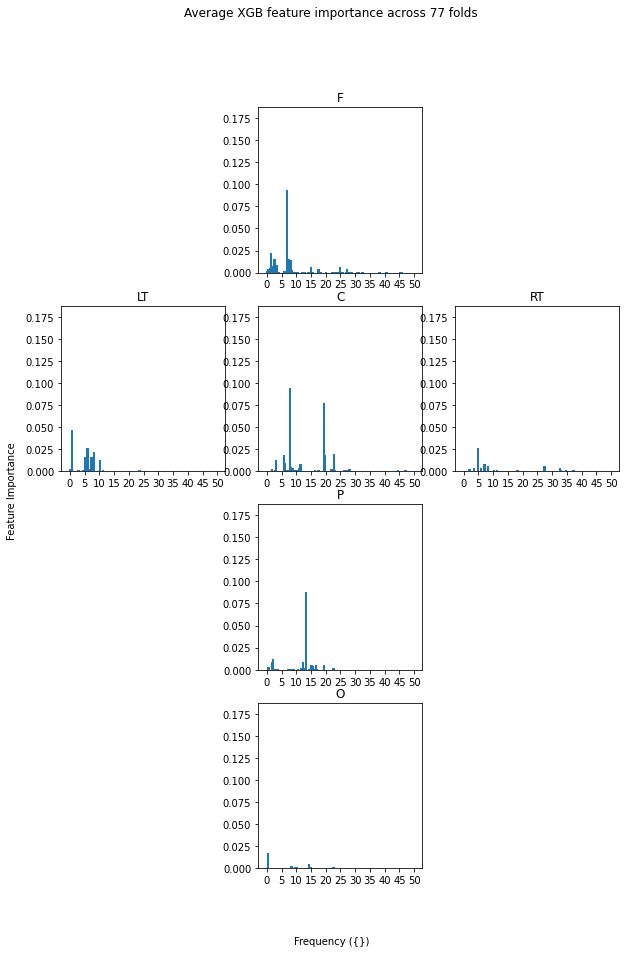

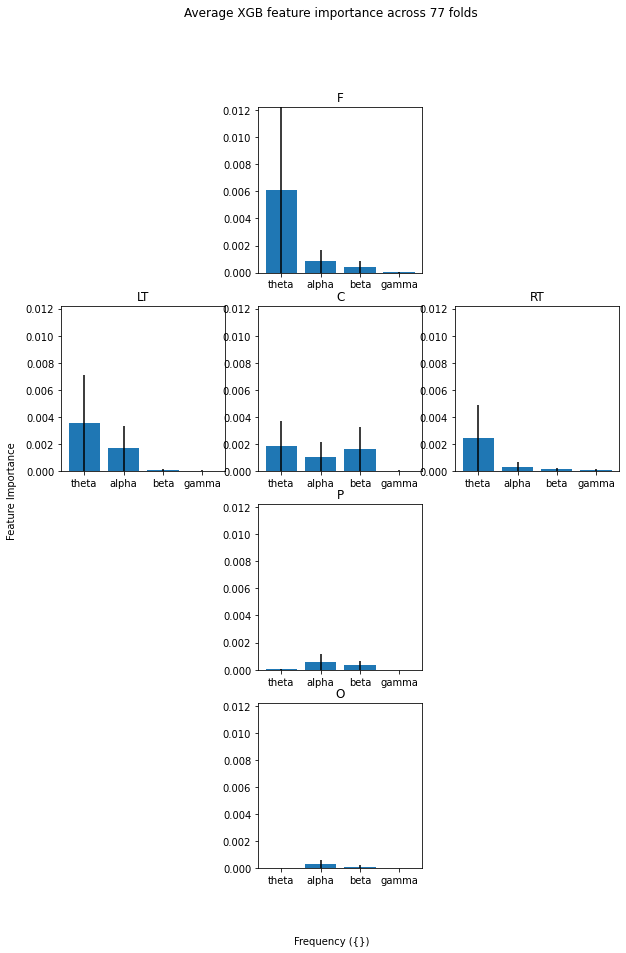

In [4]:
# L1: Features selected by L1 regression, save csv for further analysis in data_analysis.ipynb
# XGBoost: The gain type shows the average gain across all splits where feature was used, save mat for topoplot in topoplot_features.m
if 'L1' in feature_folder:
    df = pd.DataFrame.from_dict(selected_features)
    df.to_csv('results/{feature_folder}/select.csv'.format(feature_folder=feature_folder))
elif 'XGB' in feature_folder:
    bands = {'theta':(4,7), 'alpha':(8,13), 'beta':(14,30), 'gamma':(31,50)}
    regions = ['F','LT','C','RT','P','O']
    bandpower_regions = {region: np.zeros((len(all_feature_importances['F']), len(bands))) for region in regions}
    bandpower_regions['freq'] = bands.keys()
    bandpowers = {}
    for i_band, band in enumerate(bands.keys()):
        bandpowers[band] = []
        low, high = bands[band][0], bands[band][1]

        for i_region, region in enumerate(regions):
            
            # Average feature importances in each band
            idx = np.logical_and(xaxis >= low, xaxis <= high)
            
            bandpowers[band].append(np.mean(selected_features[region][idx]))
            bandpower_regions[region][:, i_band] = np.mean(all_feature_importances[region][:, idx], axis=1)
    
    # Save feature with feature importances more than zero as csv file
    selected_freq = {}
    for key, value in selected_features.items():
        selected_freq[key] = [list(xaxis[np.where(selected_features[key]>0)[0]])]
    df_selected_freq = pd.DataFrame.from_dict(selected_freq)
    df_selected_freq.to_csv('{folder}/XGB_selected_freq.csv'.format(folder='results/'+feature_folder))
        
    # Save as mat file
    sio.savemat('{folder}/XGB_feature_importances.mat'.format(folder='results/'+feature_folder), bandpowers)
    
    # Save bandpower as json file
    with open('{}/XGB_feature_importances_bandpower.json'.format('results/'+feature_folder), 'w') as f:
        json.dump(bandpowers, f)
        
    # Plot feature importance in Hz
    visualize.plot_XGB_feature_importance(all_feature_importances, feature_folder, xaxis='Hz')
    
    # Plot feature importance in band
    visualize.plot_XGB_feature_importance(bandpower_regions, feature_folder, xaxis='band', error_bar=True)
    

In [10]:
np.std(bandpower_regions['F'], axis=0)

array([3.53671657e-03, 4.65725583e-04, 2.63894422e-04, 3.52694148e-05])

In [11]:
np.mean(bandpower_regions['F'], axis=0)

array([6.10759105e-03, 8.37379663e-04, 4.43427916e-04, 3.20815877e-05])

# Find highest performance among multiple csv files

In [5]:
import glob
import itertools

data_name = 'bp_1_50_classification_resting_ASR_ref_label2'
save = True
main_metric = 'Val_acc'    # Main metric for comparison

val_methods = ['KFold', 'LOO', 'LOSO']
metrics = ['acc', 'recall', 'precision', 'f1']
df_record = pd.read_csv('./results/record.csv', index_col=0)
list_result = []
list_result.append('{folder}_{metric}'.format(folder=data_name, metric=main_metric))
for val_method in val_methods:
    
    # Modify here to compare different files
    files = glob.glob('./results/{folder}/label2_*_{val}_{coherence}_*_{imbalance}.csv'.format(
        folder=data_name, val=val_method, coherence='None', imbalance='SMOTE'
        )
    )
    max_metric, max_file = 0, ''

    for file in files:

        df = pd.read_csv(file)
        metric = df.loc[len(df)-1, main_metric]

        if metric>max_metric:
            max_metric, max_file = metric, file

    df = pd.read_csv(max_file)
    print(max_file)
    for metric in metrics:
        print('Best {metric}: {value:5.3f}'.format(metric=metric, value=df.loc[len(df)-1,'Val_'+str(metric)])) 
    # Append model name
    list_result.append(max_file.split('/')[-1])   
    
    # Append metrics of the model
    for metric in ['Val_acc', 'Val_recall', 'Val_precision', 'Val_f1']:
        list_result.append(df.loc[len(df)-1, metric])
        
if save:
    if len(df_record) == 0:
        df_record = pd.DataFrame(
            [list_result],
            columns = ['input_target'] + [
            '{val}_{metric}'.format(val=val,metric=metric) for val, metric in list(
                itertools.product(val_methods,['model']+metrics)
            )
        ])
    else:
        df_record.loc[len(df_record)] = list_result
    df_record.to_csv('./results/record.csv')


./results/bp_1_50_classification_resting_ASR_ref_label2/label2_xgboost_KFold_None_None_SMOTE.csv
Best acc: 0.792
Best recall: 0.500
Best precision: 0.500
Best f1: 0.500
./results/bp_1_50_classification_resting_ASR_ref_label2/label2_xgboost_LOO_None_None_SMOTE.csv
Best acc: 0.792
Best recall: 0.500
Best precision: 0.500
Best f1: 0.500
./results/bp_1_50_classification_resting_ASR_ref_label2/label2_svm_LOSO_None_L1select_SMOTE.csv
Best acc: 0.779
Best recall: 0.438
Best precision: 0.467
Best f1: 0.452


# Plot grouped bar chart of metrics of best preprocessing for each model

./results/psd_1_50_classification_resting_ASR_ref_label2/label2_naive_LOO_None_L1select_SMOTE.csv
Best acc: 0.766
Best recall: 0.688
Best precision: 0.458
Best f1: 0.550
./results/psd_1_50_classification_resting_ASR_ref_label2/label2_svm_LOO_None_StdScale_SMOTE.csv
Best acc: 0.805
Best recall: 0.625
Best precision: 0.526
Best f1: 0.571
./results/psd_1_50_classification_resting_ASR_ref_label2/label2_random_forest_LOO_None_None_SMOTE.csv
Best acc: 0.766
Best recall: 0.562
Best precision: 0.450
Best f1: 0.500
./results/psd_1_50_classification_resting_ASR_ref_label2/label2_xgboost_LOO_None_None_SMOTE.csv
Best acc: 0.818
Best recall: 0.438
Best precision: 0.583
Best f1: 0.500


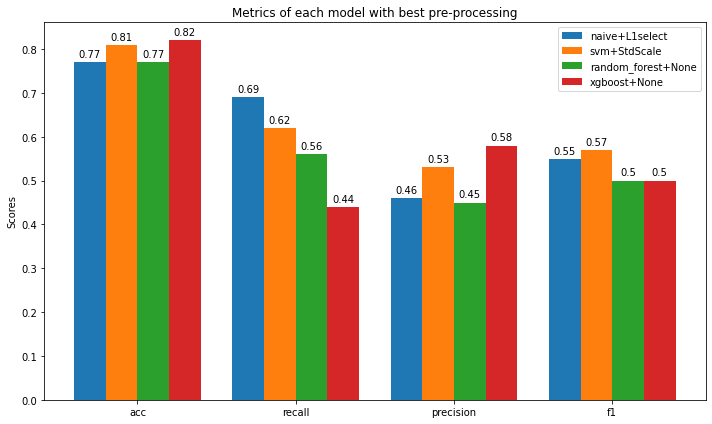

In [20]:
import glob
import itertools

data_name = 'psd_1_50_classification_resting_ASR_ref_label2'
save = False
main_metric = 'Val_f1'    # Main metric for comparison

# Find best preprocessing for each model
models = ['naive', 'svm', 'random_forest', 'xgboost']
metrics = ['acc', 'recall', 'precision', 'f1']
metric_dict = {model: [] for model in models}
preprocess_list = []

for model in models:
    
    # Modify here to compare different files
    files = glob.glob(
        './results/{folder}/label2_{model}_LOO_None_*_SMOTE.csv'.format(
            folder=data_name, model=model
        )
    )
    max_metric, max_file = 0, ''

    for file in files:

        df = pd.read_csv(file)
        metric = df.loc[len(df)-1, main_metric]

        if metric>max_metric:
            max_metric, max_file = metric, file

    preprocess_list.append(max_file.split('_')[-2])
    df = pd.read_csv(max_file)
    
    print(max_file)
    for metric in metrics:
        value = df.loc[len(df)-1,'Val_'+str(metric)]
        print('Best {metric}: {value:5.3f}'.format(metric=metric, value=value)) 
        metric_dict[model].append(round(value,2))

# Plot bar chart
width = 0.2  # the width of the bars
x = np.arange(len(metrics))   # label locations

fig, ax = plt.subplots(figsize=(10,6))
width_list = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]
rects = [ax.bar(x+width_list[i], metric_dict[model], width, label='{model}+{pre}'.format(model=model, pre=preprocess_list[i])) 
         for i, model in enumerate(models)]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Metrics of each model with best pre-processing')
ax.set_xticks(x, metrics)
ax.legend()

for i in range(len(metrics)):
    ax.bar_label(rects[i], padding=3)

fig.tight_layout()
fig.savefig('./results/performance_{}.png'.format(data_name))

In [85]:
'./results/psd_4_14_classification_resting_ASR_label2/label2_naive_LOO_None_L1select_SMOTE.csv'.split('_')

['./results/psd',
 '4',
 '14',
 'classification',
 'resting',
 'ASR',
 'label2/label2',
 'naive',
 'LOO',
 'None',
 'L1select',
 'SMOTE.csv']

# K-Fold Cross Validation for hyperparameter tuning

In [35]:
def get_pipeline_parameters(model):
    
    if model == 'svm':
        pipeline = Pipeline(
            [
                ('scale',StandardScaler()),
                ('select_features',SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))),
                ('resample',SMOTE(random_state=23)),
                ('clf',svm.SVC())
            ]
        )
        parameters = {
            'clf__C' : np.linspace(0.1, 30, 300),
            'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
        }
        name_parameters = ['C', 'kernel']
    elif model == 'random_forest':
        pipeline = Pipeline(
            [
                ('resample',SMOTE(random_state=23)),
                ('clf',RandomForestClassifier())
            ]
        )
        parameters = {
            'clf__n_estimators' : np.linspace(10,100,10).astype('int'),
            'clf__max_depth' : np.linspace(1,100,10).astype('int')
        }
        name_parameters = ['n_estimators', 'max_depth']
        
    return pipeline, parameters, name_parameters

In [36]:
label_format = 4
data_folder = 'rest'

signals, Y, df_all = dataloader.read_data(label_format=label_format, data_folder=data_folder)
data = preprocessing.StressData(signals, Y, df_all)
    
# Remove bad trials
if label_format < 4:
    data.remove_trials()

# Average into regions
data.avg_channels_into_regions(mode=1)

# Transform into power
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)
powers = np.array(powers).reshape((len(powers),-1))
psds = np.array(psds)
psds = psds[...,freqs<50].reshape((len(psds),-1))
freqs = freqs[freqs<50]

X, Y = psds, data.labels

model = 'random_forest'
pipeline, parameters, name_parameters = get_pipeline_parameters(model)

scores = ['accuracy', 'recall', 'precision', 'f1']
cv = KFold(n_splits=10, shuffle=True, random_state=23)

random_cv = RandomizedSearchCV(pipeline, parameters, n_iter=100, cv=cv, scoring=scores, refit='f1', n_jobs=-1, verbose=3, return_train_score=True)
grid_cv = GridSearchCV(pipeline, parameters, cv=cv, scoring=scores, refit='f1', n_jobs=-1, verbose=3, return_train_score=True)

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [37]:
grid_cv.fit(X, Y)

print('Best Parameters: ', grid_cv.best_params_)
print('Best f1 scores: ', grid_cv.best_score_)
print('Best recall: ', np.max(grid_cv.cv_results_['mean_test_recall']))
print('Best precision: ', np.max(grid_cv.cv_results_['mean_test_precision']))
print('Best accuracy: ', np.max(grid_cv.cv_results_['mean_test_accuracy']))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:  1.0min remaining:    0.4s


Best Parameters:  {'clf__max_depth': 1, 'clf__n_estimators': 20}
Best f1 scores:  0.55
Best recall:  0.65
Best precision:  0.6
Best accuracy:  0.6833333333333333


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


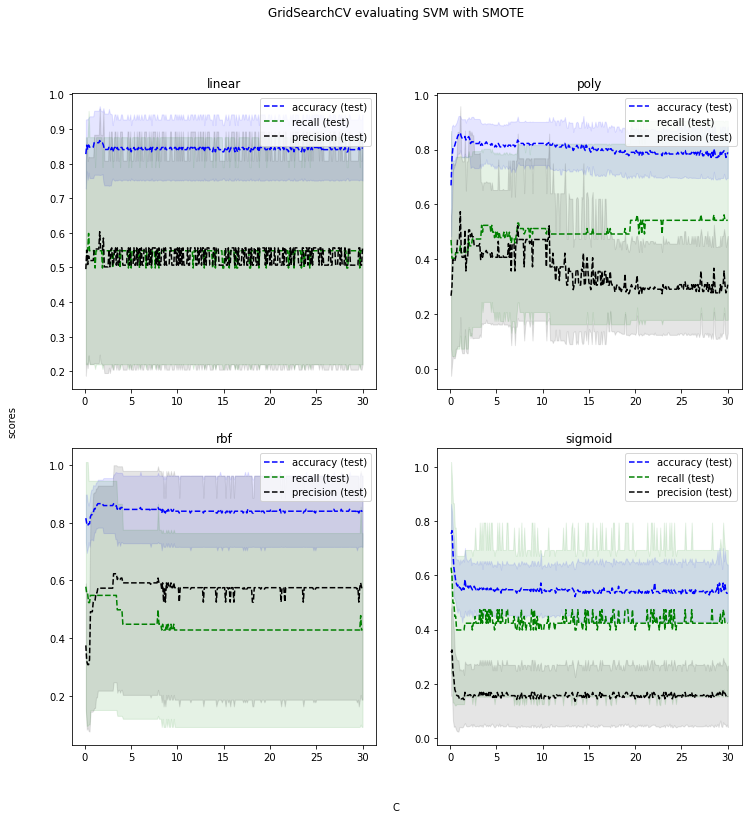

In [4]:
# Plot results for svm
fig, axs = plt.subplots(2,2, figsize=(12,12))
fig.suptitle('GridSearchCV evaluating %s with SMOTE'%(model))
fig.text(0.5, 0.05, 'C', ha='center')
fig.text(0.05, 0.5, 'scores', va='center', rotation='vertical')
X_axis = np.array(results['param_clf__%s'%(name_parameters[0])].data, dtype=float)[::4]

for i_plot, kernel in enumerate(parameters['clf__%s'%(name_parameters[1])]):
    
    row, col = i_plot//2, i_plot%2
    
    for scorer, color in zip(scores, ['b','g','k']):
        
        for sample, style in (('train','-'), ('test','--')):
            
            if sample == 'train':
                continue
            
            sample_score_mean = results['mean_%s_%s'%(sample, scorer)][i_plot::4]
            sample_score_std = results['std_%s_%s'%(sample, scorer)][i_plot::4]

            axs[row,col].fill_between(X_axis, sample_score_mean+sample_score_std, sample_score_mean-sample_score_std,
                                      alpha=0.1 if sample=='test' else 0, color=color)
            axs[row,col].plot(X_axis, sample_score_mean, style, color=color,
                              alpha=1 if sample=='test' else 0.7, label='%s (%s)'%(scorer, sample))
            
            axs[row, col].legend()
            axs[row, col].set_title(kernel)

In [2]:
'''
# Reset record.csv
keys = {}
keys['input_target'] = []
for val_method in ['KFold', 'LOO', 'LOSO']:
    for metric in ['model', 'accuracy', 'recall', 'precision', 'f1']:
        keys[val_method+'_'+metric] = []

df = pd.DataFrame(keys)
df.to_csv('./results/record.csv')
'''